## Importing Libraries

In [175]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.optimize import minimize

## Global Variables

In [176]:
x_min_global, x_max_global = 0, 0
y_min_global, y_max_global = 0, 0

## Reading the CSV File

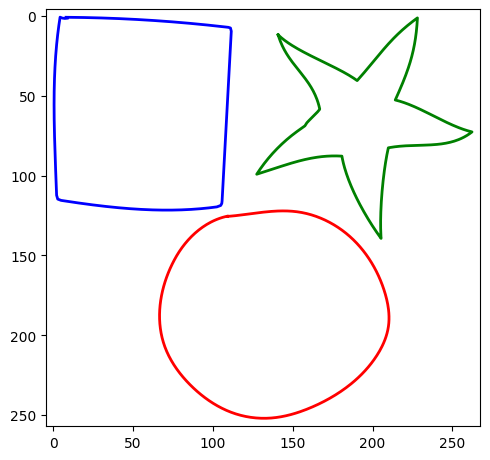

In [177]:
def read_csv(csv_path):
    global x_min_global, x_max_global, y_min_global, y_max_global
    
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    
    # Initialize min and max values for x and y coordinates
    x_min_global, x_max_global = float('inf'), float('-inf')
    y_min_global, y_max_global = float('inf'), float('-inf')
    
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
            
            # Update global min and max values for x and y
            x_min_global = int(min(x_min_global, XY[:, 0].min()))
            x_max_global = int(max(x_max_global, XY[:, 0].max()))
            y_min_global = int(min(y_min_global, XY[:, 1].min()))
            y_max_global = int(max(y_max_global, XY[:, 1].max()))
            
        path_XYs.append(XYs)
    
    return path_XYs

def plot(paths_XYs):
    colours = ['r', 'g', 'b', 'c', 'm', 'y', 'k']  # Define a list of colors to use
    fig, ax = plt.subplots(tight_layout=True, figsize=(5, 5))
    
    # Find the overall bounds of the plot
    all_x_coords = []
    all_y_coords = []
    
    for i, XYs in enumerate(paths_XYs):
        for XY in XYs:
            all_x_coords.extend(XY[:, 0])
            all_y_coords.extend(XY[:, 1])
            c = colours[i % len(colours)]
            ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2)
    
    # Set axis limits based on the overall min/max coordinates
    x_min, x_max = min(all_x_coords), max(all_x_coords)
    y_min, y_max = min(all_y_coords), max(all_y_coords)
    
    ax.set_xlim(x_min-5, x_max+5)
    ax.set_ylim(y_max+5, y_min-5)  # Flip the y-axis by setting y_max as the lower bound
    
    ax.set_aspect('equal')
    plt.show()

# Correctly call the plot function with the closing parenthesis
plot(read_csv(r"C:\Users\jaysw\OneDrive\Desktop\problems\isolated.csv"))

## Plotting with Contour Lines

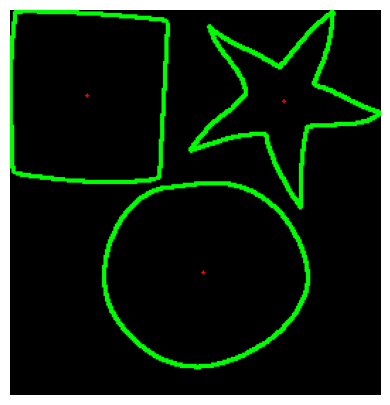

In [181]:
def plot_with_contours(paths_XYs):
    # Define a blank image with a specified size
    image_size = ((x_max_global-x_min_global+10), (y_max_global-y_min_global+10), 3)  # Adjust the size as needed
    contour_image = np.zeros(image_size, dtype=np.uint8)
    
    for i, XYs in enumerate(paths_XYs):
        for XY in XYs:
            # Convert the list of points into a contour format
            contour = np.array(XY, dtype=np.int32)
            
            # Calculate moments for the contour
            M = cv2.moments(contour)
            
            # Calculate the centroid
            if M['m00'] != 0:
                cx = int(M['m10'] / M['m00'])
                cy = int(M['m01'] / M['m00'])
                
                # Draw the contour
                cv2.drawContours(contour_image, [contour], -1, (0, 255, 0), 2)  # Green color for contours
                
                # Draw the centroid
                cv2.circle(contour_image, (cx, cy), 1, (0, 0, 255), -1)  # Red color for centroid
    
    # Display the image with contours and centroids
    plt.figure(figsize=(5, 5))
    plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

paths_XYs = read_csv((r"C:\Users\jaysw\OneDrive\Desktop\problems\isolated.csv"))
plot_with_contours(paths_XYs)

## Fitting Bezier Curves on Each Contour

In [182]:
def bezier_curve(t, p0, p1, p2, p3):
    """Compute the cubic Bézier curve points."""
    return (1 - t)**3 * p0 + 3 * (1 - t)**2 * t * p1 + 3 * (1 - t) * t**2 * p2 + t**3 * p3

def bezier_residual(params, points):
    """Compute the residual error of the Bézier curve fitting."""
    p0, p1, p2, p3 = np.split(params, 4)
    t_values = np.linspace(0, 1, len(points))
    curve_points = np.array([bezier_curve(t, p0, p1, p2, p3) for t in t_values])
    return np.sum((points - curve_points) ** 2)

def fit_bezier_curve(points):
    """Fit a cubic Bézier curve to the given points."""
    initial_params = np.concatenate([points[0], points[len(points)//3], points[2*len(points)//3], points[-1]])
    result = minimize(bezier_residual, initial_params, args=(points,))
    p0, p1, p2, p3 = np.split(result.x, 4)
    return p0, p1, p2, p3

In [183]:
def plot_bezier_curve_on_contour(contour, image_size, centroid):
    """Plot Bézier curve on the image for a single contour."""
    contour_image = np.zeros(image_size, dtype=np.uint8)
    
    # Translate contour points to center around the centroid
    translated_contour = contour - np.array([centroid[0], centroid[1]])
    
    # Fit Bézier curve
    p0, p1, p2, p3 = fit_bezier_curve(translated_contour)
    
    # Compute Bézier curve points
    t_values = np.linspace(0, 1, 100)
    bezier_points = np.array([bezier_curve(t, p0, p1, p2, p3) for t in t_values])
    
    # Translate Bézier points back to the original centroid position
    bezier_points += np.array([centroid[0], centroid[1]])
    
    # Convert Bézier points to integers
    bezier_points_int = np.int32(bezier_points)
    
    # Draw the contour
    contour_int = np.int32(contour)
    cv2.drawContours(contour_image, [contour_int], -1, (0, 255, 0), 2)  # Green for contour
    
    # Draw the Bézier curve
    for i in range(len(bezier_points_int) - 1):
        cv2.line(contour_image, tuple(bezier_points_int[i]), tuple(bezier_points_int[i + 1]), (255, 0, 0), 2)  # Blue for Bézier curve
    
    # Draw the control points
    for point in np.int32([p0, p1, p2, p3]):
        cv2.circle(contour_image, tuple(point), 5, (0, 0, 255), -1)  # Red for control points
    
    # Draw the centroid
    cv2.circle(contour_image, (centroid[0], centroid[1]), 5, (0, 255, 255), -1)  # Yellow for centroid
    
    # Display the image
    plt.figure(figsize=(5, 5))
    plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

def plot_with_contours(paths_XYs):
    """Plot contours and Bézier curves for each contour."""
    image_size = ((x_max_global - x_min_global + 10), (y_max_global - y_min_global + 10), 3)
    
    for i, XYs in enumerate(paths_XYs):
        for XY in XYs:
            contour = np.array(XY, dtype=np.int32)
            M = cv2.moments(contour)
            
            if M['m00'] != 0:
                cx = int(M['m10'] / M['m00'])
                cy = int(M['m01'] / M['m00'])
                centroid = (cx, cy)
                
                # Plot Bézier curve for the current contour
                plot_bezier_curve_on_contour(contour, image_size, centroid)

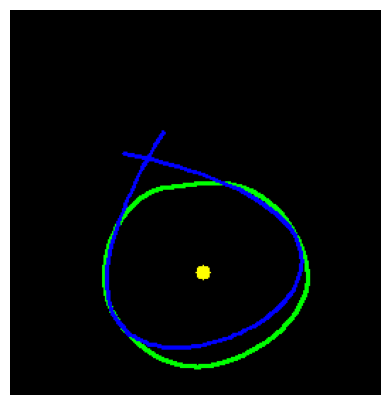

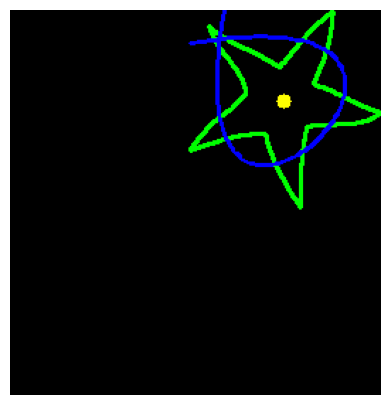

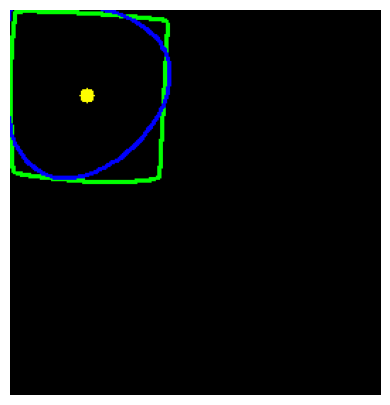

In [184]:
plot_with_contours(paths_XYs)

## Detection of Shapes

In [185]:
def aspect_ratio(contour):
    x, y, w, h = cv2.boundingRect(contour)
    return float(w) / h

def simplify_contour(contour, epsilon=0.02):
    contour = np.array(contour, dtype=np.int32).reshape((-1, 1, 2))
    epsilon = epsilon * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    return approx

def contour_area_to_bounding_box_area_ratio(contour):
    contour_area = cv2.contourArea(contour)
    x, y, w, h = cv2.boundingRect(contour)
    bounding_box_area = w * h
    return float(contour_area) / bounding_box_area

def solidity(contour):
    hull = cv2.convexHull(contour)
    hull_area = cv2.contourArea(hull)
    contour_area = cv2.contourArea(contour)
    return float(contour_area) /(hull_area + 1)

def detect_shape(contour):
    contour = simplify_contour(contour)
    ar = aspect_ratio(contour)
    area_ratio = contour_area_to_bounding_box_area_ratio(contour)
    sol = solidity(contour)
    edges = len(contour)

    # Logic for shape detection based on calculated features
    if edges == 3:
        return "Triangle", 1.0
    elif edges == 4:
        if 0.9 <= ar <= 1.1:
            return "Square", 1.0
        else:
            return "Rectangle", 1.0
    elif edges > 4:
        if 0.7 < area_ratio < 1.2:
            if ar < 1.2:
                return "Circle", 0.9
            else:
                return "Ellipse", 0.9
        elif sol < 0.8:
            return "Star", 0.9
        else:
            return "Polygon", 0.9
    else:
        return "Unknown", 0.5

def plot_contours_with_annotations(path_XYs):
    plt.figure()
    for contour_id, contour in enumerate(path_XYs):
        contour = np.array(contour, dtype=np.float32)
        shape, probability = detect_shape(contour)
        
        # Convert contour to a 2D array for plotting
        if contour.ndim == 3:
            contour = np.squeeze(contour)
        if contour.ndim == 1:
            contour = contour.reshape(-1, 2)
        
        plt.plot(contour[:, 0], contour[:, 1], 'b-')
        
        # Calculate centroid for placing annotation
        M = cv2.moments(contour)
        if M['m00'] != 0:
            cx = int(M['m10'] / M['m00'])
            cy = int(M['m01'] / M['m00'])
        else:
            cx, cy = contour[0, 0]

        plt.text(cx, cy, f'{shape} ({probability:.2f})', fontsize=9, color='red')

    plt.gca().invert_yaxis()
    plt.show()

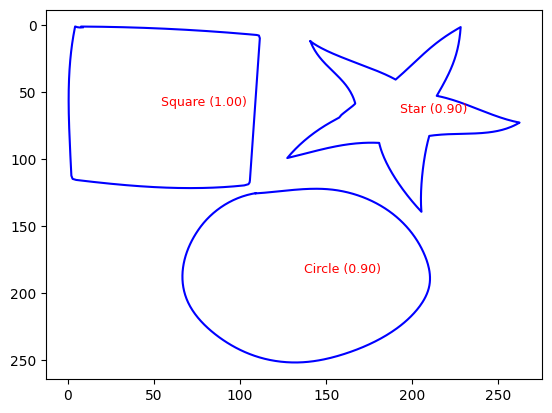

In [186]:
plot_contours_with_annotations(paths_XYs)

## Regularization of Shapes

In [189]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def fit_circle(contour):
    contour = np.squeeze(contour)
    x = contour[:, 0]
    y = contour[:, 1]
    x_m = np.mean(x)
    y_m = np.mean(y)
    u = x - x_m
    v = y - y_m
    Suu = np.sum(u ** 2)
    Suv = np.sum(u * v)
    Svv = np.sum(v ** 2)
    Suuu = np.sum(u ** 3)
    Svvv = np.sum(v ** 3)
    Suvv = np.sum(u * v ** 2)
    Svuu = np.sum(v * u ** 2)
    A = np.array([[Suu, Suv], [Suv, Svv]])
    B = np.array([Suuu + Suvv, Svvv + Svuu]) / 2.0
    uc, vc = np.linalg.solve(A, B)
    xc = x_m + uc
    yc = y_m + vc
    r = np.sqrt(uc**2 + vc**2 + (Suu + Svv) / len(x))
    theta = np.linspace(0, 2 * np.pi, 100)
    circle = np.array([xc + r * np.cos(theta), yc + r * np.sin(theta)]).T
    return circle

def detect_sharp_changes(contour, threshold=0.1):
    contour = np.squeeze(contour)
    if contour.shape[0] < 2:
        return np.array([0, len(contour) - 1])
    directions = np.diff(contour, axis=0)
    angles = np.arctan2(directions[:, 1], directions[:, 0])
    angle_diffs = np.abs(np.diff(angles))
    sharp_turns = np.where(angle_diffs > threshold)[0] + 1
    sharp_turns = np.concatenate(([0], sharp_turns, [len(contour) - 1]))
    return sharp_turns

def straighten_edges(contour):
    contour = np.squeeze(contour)
    if len(contour) < 2:
        return contour
    sharp_turns = detect_sharp_changes(contour)
    straightened = []
    for i in range(len(sharp_turns) - 1):
        start = sharp_turns[i]
        end = sharp_turns[i + 1]
        segment = contour[start:end+1]
        if len(segment) > 1:
            [vx, vy, x, y] = cv2.fitLine(segment, cv2.DIST_L2, 0, 0.01, 0.01)
            for t in np.linspace(0, 1, 100):
                straightened.append((x + t * vx, y + t * vy))
    return np.array(straightened)

def correct_polygon_shape(contour, num_sides):
    contour = np.squeeze(contour)
    if num_sides < 3:
        return contour
    # Approximate the polygon by its vertices
    epsilon = 0.01 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    vertices = approx.reshape(-1, 2)
    # Reconnect vertices to form straight edges
    corrected = []
    for i in range(len(vertices)):
        start = vertices[i]
        end = vertices[(i + 1) % len(vertices)]
        line_segment = np.linspace(start, end, num=100)
        corrected.extend(line_segment)
    return np.array(corrected)

def detect_and_correct_contour(contour):
    if len(contour) == 0:
        return contour  # Return empty contour as is
    
    if isinstance(contour, list):
        contour = np.array(contour, dtype=np.float32)
    
    if contour.ndim == 3:
        contour = np.squeeze(contour)
    
    contour = np.array(contour, dtype=np.int32)
    shape, _ = detect_shape(contour)
    
    if shape == "Circle":
        return fit_circle(contour)
    elif shape == "Star":
        return correct_polygon_shape(contour, num_sides=5)
    elif shape == "Square":
        return correct_polygon_shape(contour, num_sides=4)
    elif shape == "Rectangle":
        return correct_polygon_shape(contour, num_sides=4)
    elif shape == "Polygon":
        return correct_polygon_shape(contour, num_sides=len(contour))
    else:
        return contour.reshape(-1, 2)

def plot_corrected_image(corrected_contours):
    plt.figure()
    for i, contour in enumerate(corrected_contours):
        if contour.size == 0:
            print(f"Contour {i} is empty and will not be plotted.")
            continue
        if isinstance(contour, list):
            contour = np.array(contour, dtype=np.float32)
        if contour.ndim == 3:
            contour = np.squeeze(contour)
        if contour.ndim == 1:
            contour = contour.reshape(-1, 2)
        plt.plot(contour[:, 0], contour[:, 1], 'b-', label=f'Contour {i}')
    # plt.legend()
    plt.gca().invert_yaxis()
    plt.show()

def analyze_and_correct_contours(path_XYs):
    corrected_contours = []
    for contour in path_XYs:
        corrected_contour = detect_and_correct_contour(contour)
        corrected_contours.append(corrected_contour)
    plot_corrected_image(corrected_contours)

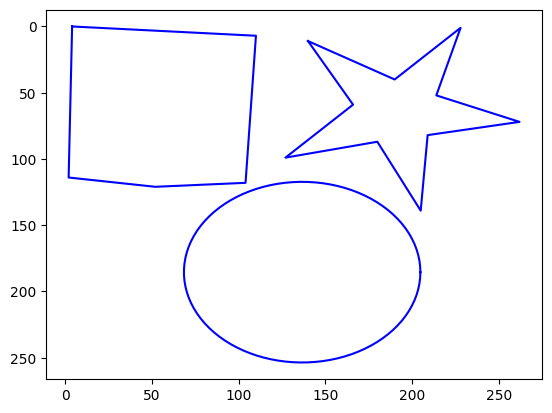

In [191]:
analyze_and_correct_contours(paths_XYs)

## Rotational and Reflection Symmetry

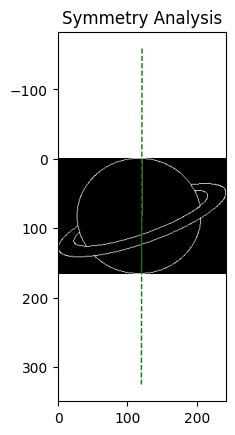

In [203]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def check_horizontal_symmetry(img, tolerance=0.05):
    height, width = img.shape
    half_height = height // 2
    if height % 2 == 0:
        top_half = img[:half_height, :]
        bottom_half = img[half_height:, :]
    else:
        top_half = img[:half_height, :]
        bottom_half = img[half_height + 1:, :]
    
    return np.mean(np.abs(top_half - np.flipud(bottom_half[:top_half.shape[0], :]) > tolerance)) < tolerance

def check_vertical_symmetry(img, tolerance=0.05):
    height, width = img.shape
    half_width = width // 2
    if width % 2 == 0:
        left_half = img[:, :half_width]
        right_half = img[:, half_width:]
    else:
        left_half = img[:, :half_width]
        right_half = img[:, half_width + 1:]
    
    return np.mean(np.abs(left_half - np.fliplr(right_half[:, :left_half.shape[1]]) > tolerance)) < tolerance

def calculate_similarity(img1, img2, tolerance=0.05):
    """Calculate similarity between two images allowing for a tolerance."""
    return np.mean(np.abs(img1 - img2) < tolerance)

def check_rotational_symmetry(img, step=1, tolerance=0.01, similarity_threshold=0.95):
    height, width = img.shape
    angles_with_symmetry = []
    
    for angle in range(0, 180, step):
        rotated = cv2.warpAffine(img, cv2.getRotationMatrix2D((width // 2, height // 2), angle, 1.0), (width, height))
        
        # Split the image into left and right halves
        half_width = width // 2
        left_half = rotated[:, :half_width]
        right_half = rotated[:, half_width:]
        
        # Resize right_half to match left_half dimensions if needed
        if right_half.shape[0] != left_half.shape[0]:
            right_half = cv2.resize(right_half, (left_half.shape[1], left_half.shape[0]))

        similarity = calculate_similarity(left_half, np.fliplr(right_half))  # Compare left_half with flipped right_half

        if similarity >= similarity_threshold:  # Check if similarity meets the threshold
            angles_with_symmetry.append(angle)
    
    return angles_with_symmetry

def draw_symmetry_lines(img, angles):
    height, width = img.shape
    img_with_lines = img.copy()
    
    for angle in angles:
        radians = np.deg2rad(angle)
        center = (width // 2, height // 2)
        length = max(width, height)  # Length of the line across the image
        
        pt1 = (int(center[0] + length * np.cos(radians)),
               int(center[1] - length * np.sin(radians)))
        pt2 = (int(center[0] - length * np.cos(radians)),
               int(center[1] + length * np.sin(radians)))
        
        cv2.line(img_with_lines, pt1, pt2, 127, 1)  # Draw the symmetry line (gray color for visibility)
    
    return img_with_lines

def paths_to_image(path_XYs, img_size):
    img = np.zeros(img_size, dtype=np.uint8)
    for paths in path_XYs:
        for path in paths:
            for i in range(len(path) - 1):
                pt1 = (int(path[i, 0]), int(path[i, 1]))
                pt2 = (int(path[i + 1, 0]), int(path[i + 1, 1]))
                cv2.line(img, pt1, pt2, 255, 1)
    # return cv2.transpose(img)[::-1]
    return img

def plot_image_with_symmetries(img, symmetry_angles):
    fig, ax = plt.subplots()
    ax.imshow(img, cmap='gray')
    
    for angle in symmetry_angles:
        radians = np.deg2rad(angle)
        center = (img.shape[1] // 2, img.shape[0] // 2)
        length = max(img.shape)
        
        pt1 = (int(center[0] + length * np.cos(radians)),
               int(center[1] - length * np.sin(radians)))
        pt2 = (int(center[0] - length * np.cos(radians)),
               int(center[1] + length * np.sin(radians)))
        
        ax.plot([pt1[0], pt2[0]], [pt1[1], pt2[1]], color='g', linestyle='--', linewidth=1, label=f'Symmetry Line at {angle}°')

    plt.title('Symmetry Analysis')
    plt.show()

def analyze_path_XYs(csv_path):
    path_XYs = read_csv(csv_path)
    
    img_size = (y_max_global - y_min_global + 1, x_max_global - x_min_global + 1)
    img = paths_to_image(path_XYs, img_size)
    
    symmetry_angles = check_rotational_symmetry(img)
    
    img_with_lines = draw_symmetry_lines(img, symmetry_angles)
    
    plot_image_with_symmetries(img_with_lines, symmetry_angles)

# Example usage
csv_path = r"C:\Users\jaysw\OneDrive\Desktop\problems\occlusion2.csv"
analyze_path_XYs(csv_path)
